In [3]:
import numpy as np
from scipy.optimize import linprog, nnls, minimize
from numpy.linalg import solve, lstsq
from pyxrf.model.command_tools import fit_pixel_data_and_save
import os
import matplotlib.pylab as plt
from PIL import Image
import matplotlib.image as mpimg
import skimage

C:\Users\Derek\Anaconda3\envs\pyxrf_test\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [6]:
#Create function for quick data acqusistion from txt files.
#Another function is then made for finding the closest matching
#values from multiple data sets.

def dataFromFile(filename, colnum=1):
    """
    Extract data from file and return data is two 1D numpy arrays.
    File is assumed to be formated such that each row is an x,y pair.
    """
    xdata = np.empty([1, 0])
    ydata = np.empty([1, 0])
    count = 0
    if colnum!=1:
        for line in filename:
            for word in line.split():
                if count == 0:
                    xdata = np.append(xdata, float(word))
                    count = count+1
                else:
                    ydata = np.append(ydata, (float(word)))
                    count = 0
    else:
        for line in filename:
            for word in line.split():
                xdata = np.append(xdata, float(word))
    return xdata,ydata

#Find indices in x2data closest to xdata
def find_indicies(xdata, x2data):
    """
    Compares each value in x2data by all values in xdata to find
    which value in xdata is closest to given value in x2data.
    The clostest values are saved into 1D numpy array and returned.
    This is done to accomodate the fact that data in the form of 
    (incident beam energy, intensity) will not have incident beam energy
    values which match exactly.
    
    Parameters
    ----------
    xdata: 1D numpy array
        Array filled with values corresponding to incident beam energy
        
    x2data: 1D numpy array
        Same description as xdata
    """
    count = 0
    count2 = 0
    index = 0
    diff1 = 0
    diff2 = 1000
    xdiff = np.empty([1, 0])
    for val in xdata:
        for num in x2data:
            diff1 = abs(num - val)
            if(diff1 < diff2):
                diff2 = diff1
                index = count
            count = count + 1
        xdiff = np.append(xdiff, x2data[index])
        diff2 = 100000
        count2 = count2 + 1
        count = 0
    return xdiff

def makeBinaryMask(array, limit):
    mask = np.zeros(array.shape)
    row = np.arange(array.shape[0])
    col = np.arange(array.shape[1])
    for val in row:
        for val2 in col:
            if(array[val][val2] >= limit):
                mask[val][val2] = 1
    return mask
"""
array = np.load('1_arr.npy')
im = Image.open('1.tiff')#os.getcwd()+'/pics/detsum_Ni_K_12600.tiff')
limit = 0
mask = makeBinaryMask(array, limit)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(mask)
plt.colorbar()
plt.show()
"""

"\narray = np.load('1_arr.npy')\nim = Image.open('1.tiff')#os.getcwd()+'/pics/detsum_Ni_K_12600.tiff')\nlimit = 0\nmask = makeBinaryMask(array, limit)\nfig = plt.figure()\nax = fig.add_subplot(111)\nplt.imshow(mask)\nplt.colorbar()\nplt.show()\n"

In [31]:
#Open necessary files for data acquisition
fx  = open('energy.txt', 'r')
fy = open('roi_data.txt', 'r')
f2 = open('Ni2+.txt', 'r')
f3 = open('Ni3+.txt', 'r')
f4 = open('Ni4+.txt', 'r')

#Initialize necessary 1D numpy arrays
xdata = np.empty([1, 0])
ydata = np.empty([1, 0])
xdata2 = np.empty([1, 0])
ydata2 = np.empty([1, 0])
xdata3 = np.empty([1, 0])
ydata3 = np.empty([1, 0])
xdata4 = np.empty([1, 0])
ydata4 = np.empty([1, 0])

#Obtain experimental incident beam energy data and total intensity integrated over some ROI
for val in fx:
    xdata = np.append(xdata, float(val))
for val in fy:
    ydata = np.append(ydata, float(val))

xplot = xdata
yplot = ydata

#Obtain XANES data for Ni oxidation states 2+,3+,4+
xdata2, ydata2 = dataFromFile(f2, colnum=2)
xdata3, ydata3 = dataFromFile(f3, colnum = 2)
xdata4, ydata4 = dataFromFile(f4,colnum=2)

#Find closest incident beam energy values between experimental and XANES data
#Division by 1000 for normalization
xdiff2 = find_indicies(xdata, xdata2/1000)
xdiff3 = find_indicies(xdata, xdata3/1000)
xdiff4 = find_indicies(xdata, xdata4/1000)

#Obtain intensity values from XANES data which matched best with experimental data
count = 0
ydiff2 = np.empty([1,0])
for val in xdiff2:
    #print(np.where(x2data/1000==val))
    ydiff2 = np.append(ydiff2, ydata2[np.where(xdata2/1000==val)]) 
    count = count + 1

count = 0
ydiff3 = np.empty([1, 0])
for val in xdiff3:
    ydiff3 = np.append(ydiff3, ydata3[np.where(xdata3/1000==val)])
    count = count+1

count = 0
ydiff4 = np.empty([1, 0])
for val in xdiff4:
    ydiff4 = np.append(ydiff4, ydata4[np.where(xdata4/1000==val)])
    count = count +1    

#Create matrix and reshape to 3x9. Corresponds to matrix equation Ax = b.
#Each element is intensity of a Ni oxidation state from XANES data.
A = np.concatenate((ydiff2, ydiff3, ydiff4), axis=0)
print(A)
A.shape = (3,9)
A = A.transpose()
print(A)

#Create column vector corresponding to b in matrix equation Ax = b.
#Each column is the total intensity for a given incident beam energy.
b = np.empty([1, 0])
for val in ydata:
    b = np.append(b, val)

#Use nnls to get initial guess
x0, rnorm = nnls(A,b)

#Define minimisation function
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

#Define constraints and bounds
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1},
        {'type': 'ineq', 'fun': lambda x:  np.sum(x)})
bounds = [[0, 1],[0, 1],[0, 1]]


#Compute solution x to minimization of |Ax-b|=0
minout = minimize(fn, x0, args=(A, b), bounds=bounds, method='SLSQP',constraints=cons)
x = minout.x
#print(x)
print(minout)
#return x

[ 0.       0.59592  1.20408  1.4898   0.86939  0.67755  0.8      0.66122
  0.97959  0.       0.49796  1.02857  1.85714  1.32653  0.98776  1.08571
  0.91429  1.04898  0.       0.16327  0.43673  1.00408  1.14694  1.
  0.97143  0.8      0.97959]
[[ 0.       0.       0.     ]
 [ 0.59592  0.49796  0.16327]
 [ 1.20408  1.02857  0.43673]
 [ 1.4898   1.85714  1.00408]
 [ 0.86939  1.32653  1.14694]
 [ 0.67755  0.98776  1.     ]
 [ 0.8      1.08571  0.97143]
 [ 0.66122  0.91429  0.8    ]
 [ 0.97959  1.04898  0.97959]]
     fun: 0.32425846774590944
     jac: array([-0.68200493, -0.6820497 , -0.68212558,  0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.77206097,  0.04640756,  0.18153147])


[ 8.32   8.34   8.344  8.347  8.354  8.359  8.364  8.374  8.445] [ 0.0084487   0.59651929  1.18156808  1.267133    0.89884752  0.82780661
  0.94313995  0.90234395  1.        ]
139 135 175


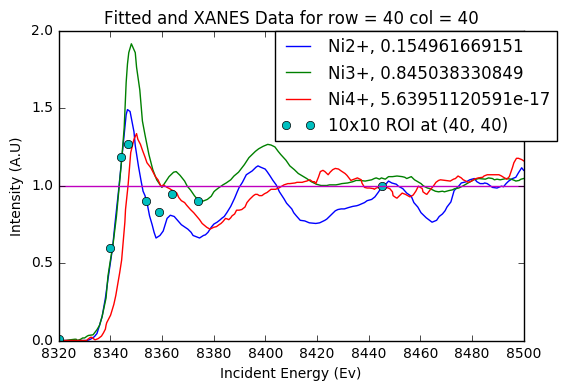

In [23]:
def inten(coeff, xanes1, xanes2, xanes3, index):
    """
    Calculate total intensity based on computed weight provided by each oxidation state.
    """
    intensity = coeff[0]*xanes1[index]+coeff[1]*xanes2[index]+coeff[2]*xanes3[index]
    return intensity

#Set up 1D numpy arrays for plotting XANES data, experimental data, and fit data
#simultaneously
xdiff2 = find_indicies(xdata3, xdata2)
xdiff4 = find_indicies(xdata3, xdata4)
print(xplot, yplot)
print(len(xdata2), len(xdata3), len(xdata4))
count = 0
ydiff2 = np.empty([1, 0])
for val in xdiff2:
    ydiff2 = np.append(ydiff2, ydata2[np.where(xdata2==val)])
    count = count+1
    
    
count = 0
ydiff4 = np.empty([1, 0])
for val in xdiff4:
    ydiff4= np.append(ydiff4, ydata4[np.where(xdata4==val)])
    count = count+1

#Weights of each oxidation state
coeff = [0.154961669151, 0.845038330849, 5.63951120591e-17]    
#coeff = [0, 1, 0]
vals = np.arange(len(xdiff2))
fitdata = np.zeros(len(xdiff2))

for num in vals:
    fitdata[num] = inten(coeff, ydiff2, ydata3, ydiff4, num)


fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(xdata, b, x2data/1000, y2data, x3data/1000, y3data, x4data/1000, y4data)
#ax.plot(xdata3, fitdata,label='fit')
ax.plot(xdata2, ydata2, label='Ni2+, '+str(coeff[0])) 
ax.plot(xdata3, ydata3, label='Ni3+, '+str(coeff[1]))
ax.plot(xdata4, ydata4, label='Ni4+, '+str(coeff[2]))
ax.plot(xplot*1000, yplot/1, marker='o', linestyle='None', label='10x10 ROI at (40, 40)')
oneLine = np.arange(0, xdata3.shape[0])
for val in oneLine:
    oneLine[val] = 1
ax.plot(xdata3, oneLine)
plt.title('Fitted and XANES Data for row = 40 col = 40')
plt.xlabel('Incident Energy (Ev)')
plt.ylabel('Intensity (A.U)')
plt.legend(bbox_to_anchor=(1.09, 1.025))
plt.savefig('fit')
plt.show()

0.174755731619 0.825244268381 0.0
(1, 9, 0.0) (0, 2, 0.0) (0, 39, 0.0)


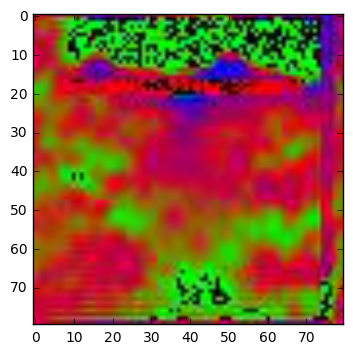

In [36]:
import matplotlib
array = np.load('dataMap1.npy')
array2 = np.load('dataMap2.npy')
array3 = np.load('dataMap3.npy')
row = np.arange(0, array.shape[0])
col = np.arange(0, array.shape[1])
for val in row:
    for val2 in col:
        if(mask[val][val2] == 0):
            array[val][val2] = 0
            array2[val][val2] = 0
            array3[val][val2] = 0
i = array.shape[0]
j = array.shape[1]
rgb = np.zeros((i, j, 3), 'uint8')
xdist = np.arange(0, array.shape[0])
ydist = np.arange(0, array.shape[1])
#for xval in xdist:
    #for yval in ydist:
        #rgb = (array[xval][yval], array2[xval][yval], array3[xval][yval])
rgb[:,:,0] = array*256
rgb[:,:,1] = array2*256
rgb[:,:,2] = array3*256
arr1 = 0
arr2 = 0
arr3 = 0
row2 = np.arange(40, 50)
col2 = np.arange(40, 50)
for val in row2:
    for val2 in col2:
        arr1 = arr1 +array[val][val2]
        arr2 = arr2 + array2[val][val2]
        arr3 = arr3 + array3[val][val2]
        
print(array[60][49], array2[60][49], array3[60][49])
i,j = np.unravel_index(array.argmin(), array.shape)
i2,j2 = np.unravel_index(array2.argmin(), array2.shape)
i3,j3 = np.unravel_index(array3.argmin(), array3.shape)
print((i, j, array[i][j]), (i2, j2, array2[i2][j2]), (i3, j3, array3[i3][j3]))
#print(array.shape)
#print(arr1/100, arr2/100, arr3/100)
#print(arr1/4, arr2/4, arr3/4)

img = Image.fromarray(rgb)
img.save('myimg.jpg')

"""
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(array)
ax2 = fig.add_subplot(111)
img2 = ax2.imshow(array2)
ax3 = fig.add_subplot(111)
img3 = ax3.imshow(array3)
#fig.colorbar(img)
ax4 = fig.add_subplot(111)
img4 = ax4.imshow(rgb)
plt.show()
#plt.imshow(img)#, clim=(0, 1))
#plt.colorbar()
#plt.show()
"""


#image = np.asarray(Image.open('myimg.jpg'))
image = Image.open('myimg.jpg')
fig = plt.figure()
ax = fig.add_subplot(111)
img = ax.imshow(image)
plt.show()